In [15]:
import polars as pl
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly import subplots
import mlxtend as mlx
import numpy as np
import pandas as pd
import statsmodels
from IPython.display import display, HTML, Image
import plotly.io as pio
import json
from urllib.request import urlopen


pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_columns = 50
pio.templates.default = "plotly_dark"

# Convert scientific notation to plain numbers
pd.options.display.float_format = '{:.2f}'.format

def display_side_by_side(*args):
    html_str = '<div style="display: flex; justify-content: flex-start;">'
    for df in args:
        if isinstance(df, pd.Series):
            df = df.to_frame()
        html_str += f'<div style="flex: 1; padding: 0;">{df.to_html(index=True)}</div>'
    html_str += '</div>'
    
    display(HTML(html_str))

In [16]:
#Again, let's do some initial exploration once again on the newly generated csv
df = pd.read_csv('online_retail_pos_stock.csv')
display_side_by_side(df.head())
display_side_by_side(df.tail())
print('-------------------------------')
print(f'Dataframe contains {df.shape[1]} columns and {df.shape[0]} rows')
print('-------------------------------')
#Get an idea of all of the dtypes that we have in this DF
dtypes_df = pd.DataFrame(df.dtypes).reset_index()
dtypes_df.columns = ['column name', 'dtype']
print(f'Unique dtypes in this DataFrame:{set(dtypes_df["dtype"].values)}')

print('-------------------------------')


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
527752,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.00,France,10.20
527753,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.00,France,12.60
527754,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.00,France,16.60
527755,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.00,France,16.60
527756,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.00,France,14.85


-------------------------------
Dataframe contains 9 columns and 527757 rows
-------------------------------
Unique dtypes in this DataFrame:{dtype('int64'), dtype('O'), dtype('float64')}
-------------------------------


In [17]:
#Display all of the category names broken up by dtype again
object_df, float_df, int_df= dtypes_df[dtypes_df['dtype']== 'object'], dtypes_df[dtypes_df['dtype']== 'float64'], dtypes_df[dtypes_df['dtype']== 'int64']
display_side_by_side(object_df, float_df,  int_df)

print('-------------------------------')
from statsmodels.stats import descriptivestats
#Get an overview of our other numerical columns
stats_df = descriptivestats.describe(df.drop('InvoiceNo', axis=1)).round(2)
display_side_by_side(stats_df[:15].round(2), stats_df[15:].round(2))

,column name,dtype
1,StockCode,object
2,Description,object
4,InvoiceDate,object
7,Country,object
,column name,dtype
5,UnitPrice,float64
6,CustomerID,float64
8,TotalPrice,float64
,column name,dtype
0,InvoiceNo,int64


-------------------------------


,Quantity,UnitPrice,CustomerID,TotalPrice
nobs,527757.00,527757.00,527757.00,527757.00
missing,0.00,0.00,131420.00,0.00
mean,10.57,3.27,15301.69,19.46
std_err,0.21,0.01,2.72,0.37
upper_ci,10.99,3.28,15307.01,20.19
lower_ci,10.15,3.25,15296.37,18.74
std,155.83,4.38,1709.96,268.61
iqr,10.00,2.88,2828.00,13.65
iqr_normal,7.41,2.13,2096.40,10.12
mad,11.14,2.33,1475.69,18.23


In [18]:
# To help out with our analysis, we will create new datetime columns and adjust the dtypes on existing ones
#Let's convert InvoiceDate into a datetime object so we can display some time-specific trends
df['InvoiceDate'] = pd.to_datetime(df["InvoiceDate"])

df['InvoiceDay'] = df['InvoiceDate'].dt.date
df['InvoiceHour'] = df['InvoiceDate'].dt.hour
df['InvoiceHour'] = df['InvoiceHour'].astype(int)
df['InvoiceDay']= pd.to_datetime(df['InvoiceDay'])

#Make a str version of our Customer IDs column for indexing purposes
df['CustomerID_str'] = df['CustomerID'].astype(str)
df['CustomerID_str'] = df['CustomerID_str'].str.replace('.0', '')
#df['CustomerID_str'] = df['CustomerID_str'].astype(str)

#Let's save our file as a parquet to save some space
df.to_parquet('online_sales_pos_stock.parquet')
df = pd.read_parquet('online_sales_pos_stock.parquet')

In [19]:
#Create a dictionary to make plotly graph generation more efficient
array_dicts = {}
for col in df.columns.to_list():
    array_dicts[col] = np.array(df[col])

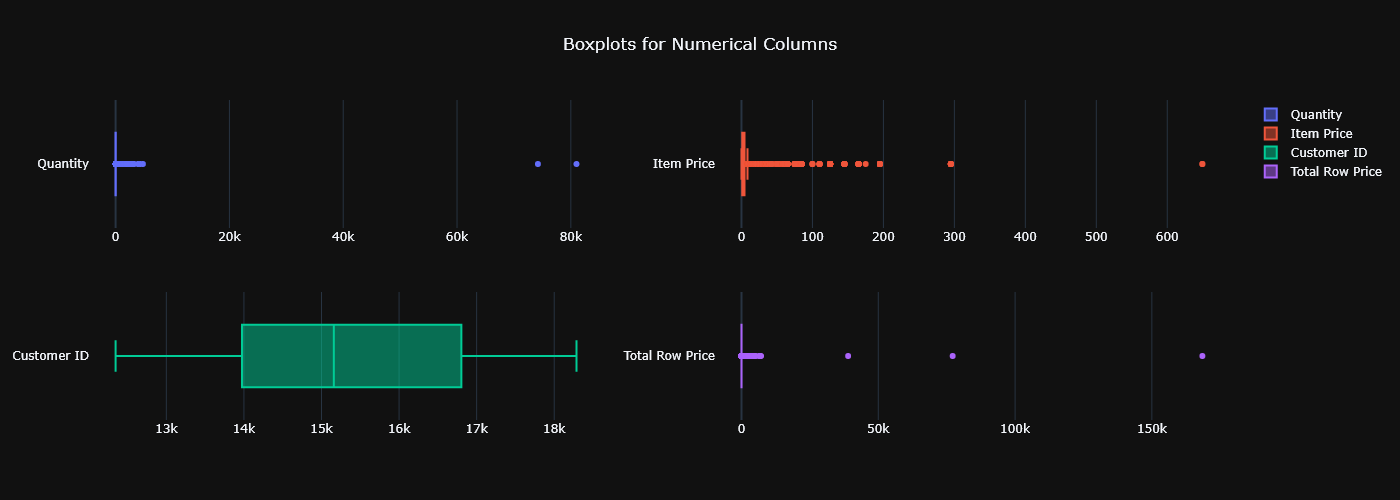

In [20]:
#Create some boxplots to see how our values are distributed
fig = subplots.make_subplots(rows=2, cols=2, vertical_spacing=0.2)

hist1 = go.Box(x=array_dicts['Quantity'], name='Quantity')
hist2 = go.Box(x=array_dicts['UnitPrice'], name ='Item Price')
hist3 = go.Box(x=array_dicts['CustomerID'], name='Customer ID')
hist4 = go.Box(x=array_dicts['TotalPrice'], name='Total Row Price')

fig.append_trace(hist1, 1,1)
fig.append_trace(hist2, 1,2)
fig.append_trace(hist3, 2,1)
fig.append_trace(hist4, 2,2)

fig.update_layout(title = 'Boxplots for Numerical Columns', title_x = 0.5, width=1400)
pio.write_image(fig, 'boxplot_num.png')

Image('boxplot_num.png')


In [21]:
#As we can see from above, we have a lot of outliers for 3 of the 4 columns that will make histogram plots be too spread out, so we will cut each graph of first at the 99% percentile and see how many data points we will be missing from the visualization
top_percentile = stats_df.loc['99%', :]
top_percentile_reset = stats_df.loc['99%', :].reset_index()
display_side_by_side(top_percentile)

for col in top_percentile_reset['index'].to_list():
    value = float(top_percentile[col])
    print(f"Number of rows higher than {value} for {col} = {len(df[df[col] > value])}")


,99%
Quantity,100.00
UnitPrice,16.63
CustomerID,18212.00
TotalPrice,179.00


Number of rows higher than 100.0 for Quantity = 4842
Number of rows higher than 16.63 for UnitPrice = 4752
Number of rows higher than 18212.0 for CustomerID = 3930
Number of rows higher than 179.0 for TotalPrice = 5073


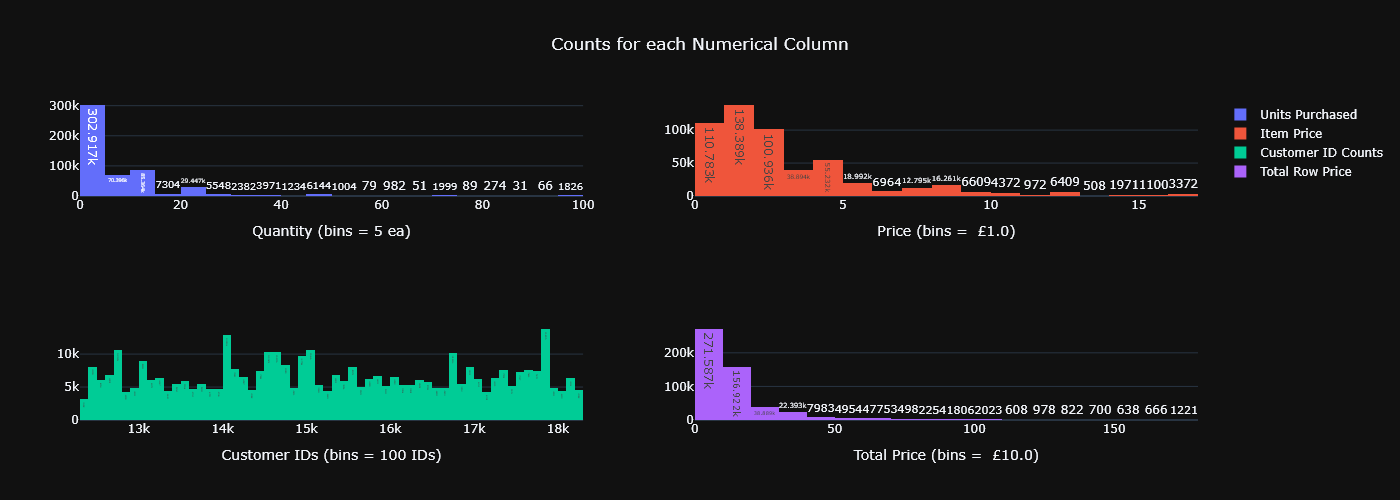

In [22]:
#That last cell output shows that at most, these rows above the 99% percentile contain a small fraction of the 500,000+ rows that make up our data so for the sole purpose of getting a better visibility of the density distributions of numerical columns, we will produce some graphs that leave them out in the meantime
fig = subplots.make_subplots(rows=2, cols=2, vertical_spacing=0.4)

hist1 = go.Histogram(x=array_dicts['Quantity'], texttemplate='%{y}',  xbins=dict(start=0, end = float(top_percentile['Quantity']), size=5), name='Units Purchased')
hist2 = go.Histogram(x=array_dicts['UnitPrice'], texttemplate='%{y}',  xbins=dict(start=0, end = float(top_percentile['UnitPrice']), size=1), name='Item Price')
hist3 = go.Histogram(x=array_dicts['CustomerID'], texttemplate='%{y}', xbins=dict(size=100), name='Customer ID Counts')
hist4 = go.Histogram(x=array_dicts['TotalPrice'],  texttemplate='%{y}',  xbins=dict(start=0, end = float(top_percentile['TotalPrice']), size=10), name='Total Row Price')

# Update x-axis labels
fig.update_xaxes(title_text=  'Quantity (bins = 5 ea)', row=1, col=1)
fig.update_xaxes(title_text='Price (bins = 	£1.0)', row=1, col=2)
fig.update_xaxes(title_text=f'Customer IDs (bins = 100 IDs)', row=2, col=1)
fig.update_xaxes(title_text=f'Total Price (bins = 	£10.0)', row=2, col=2)

fig.append_trace(hist1, 1,1)
fig.append_trace(hist2, 1,2)
fig.append_trace(hist3, 2,1)
fig.append_trace(hist4, 2,2)

fig.update_layout(title = 'Counts for each Numerical Column', title_x = 0.5, width =1400)
pio.write_image(fig, 'hist1.png')

Image('hist1.png')

In [23]:
#Turn month and hour into discrete ordinal variables for graphing purposes
#We convert these columns at this point in the notebook as doing so before saving the data as parquet gives us an error
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')

monthly_totals = df[['InvoiceMonth', 'TotalPrice']].groupby('InvoiceMonth').sum()
monthly_totals = monthly_totals.reset_index()
monthly_totals['InvoiceMonth'] = monthly_totals['InvoiceMonth'].astype(str)
monthly_totals['InvoiceMonth'].to_list()

hourly_totals = df[['InvoiceHour', 'TotalPrice']].groupby('InvoiceHour').sum()
hourly_totals = hourly_totals.reset_index()
hourly_totals['InvoiceHour'] = hourly_totals['InvoiceHour'].astype(str)


In [26]:
fig = go.Figure()
fig.add_trace(go.Bar(x = monthly_totals['InvoiceMonth'], y=np.array(monthly_totals['TotalPrice']), texttemplate='%{y}'))
fig.update_xaxes(title_text='Total Sold per Month')
fig.update_yaxes(title_text='Total Value in Pounds')
fig.update_layout(title = 'Monthly Sales Trend',xaxis=dict(tickmode='array', dtick = 1))
fig.show()

fig2 = go.Figure()
fig2.add_trace(go.Bar(x = hourly_totals['InvoiceHour'], y=np.array(hourly_totals['TotalPrice']), texttemplate='%{y}'))
fig2.update_xaxes(title_text='Sales Trend by Hour (24-hour time format)')
fig2.update_yaxes(title_text='Total Value in Pounds')
fig2.update_layout(title = 'Hourly Sales Trend', xaxis=dict(tickmode='array', dtick = 1))
fig2.show()

In [27]:
#Identify top accounts based on Sales Totals
customers_df = df[~df['CustomerID'].isna()]
top_accounts = customers_df[['CustomerID_str', 'TotalPrice']].groupby('CustomerID_str').sum()
top_accounts = top_accounts.sort_values(by='TotalPrice', ascending=False)
top_accounts = top_accounts.reset_index()
top_20_accounts = top_accounts[:20]
top_accounts_list = top_accounts[:20]['CustomerID_str'].to_list()
top_20_accounts

#Calculate percent of sales of top 20 accounts
top_accounts_percent = np.sum(top_accounts[:20]['TotalPrice'])/np.sum(df['TotalPrice'])
print(f'The Top 20 Customers make up {top_accounts_percent:.2%} of Total sales')

#Get all the transactions of the top accounts grouped by Stock Code to find most popular items
top_accounts_transactions = df[df['CustomerID_str'].isin(top_accounts_list)]
top_grouped_by_stock = top_accounts_transactions[['CustomerID_str', 'StockCode', 'TotalPrice']].groupby(['CustomerID_str', 'StockCode']).sum()
top_grouped_stock_reset = top_grouped_by_stock.reset_index()
top_grouped_stock_reset[top_grouped_stock_reset['CustomerID_str'] == top_accounts_list[0]]


The Top 20 Customers make up 20.40% of Total sales


,CustomerID_str,StockCode,TotalPrice
4540,14646,15058C,39.50
4541,14646,16161P,21.00
4542,14646,20674,70.00
4543,14646,20675,106.32
4544,14646,20676,152.64
...,...,...,...
5234,14646,85099F,839.00
5235,14646,85123A,1060.80
5236,14646,85178,367.20
5237,14646,85183B,60.00


In [29]:
#Let's display the total purchased amounts of each of the top 20 accounts
fig = px.bar(orientation='h', x=top_20_accounts['TotalPrice'], y=top_20_accounts['CustomerID_str'].astype(str),  title='Top Accounts Ordered by Total Amount Purchased in Pounds', text = top_20_accounts['TotalPrice'])
fig.update_layout(xaxis_title='Total Amount Purchased in Pounds', yaxis_title='Customer ID', height=750)
fig.show()

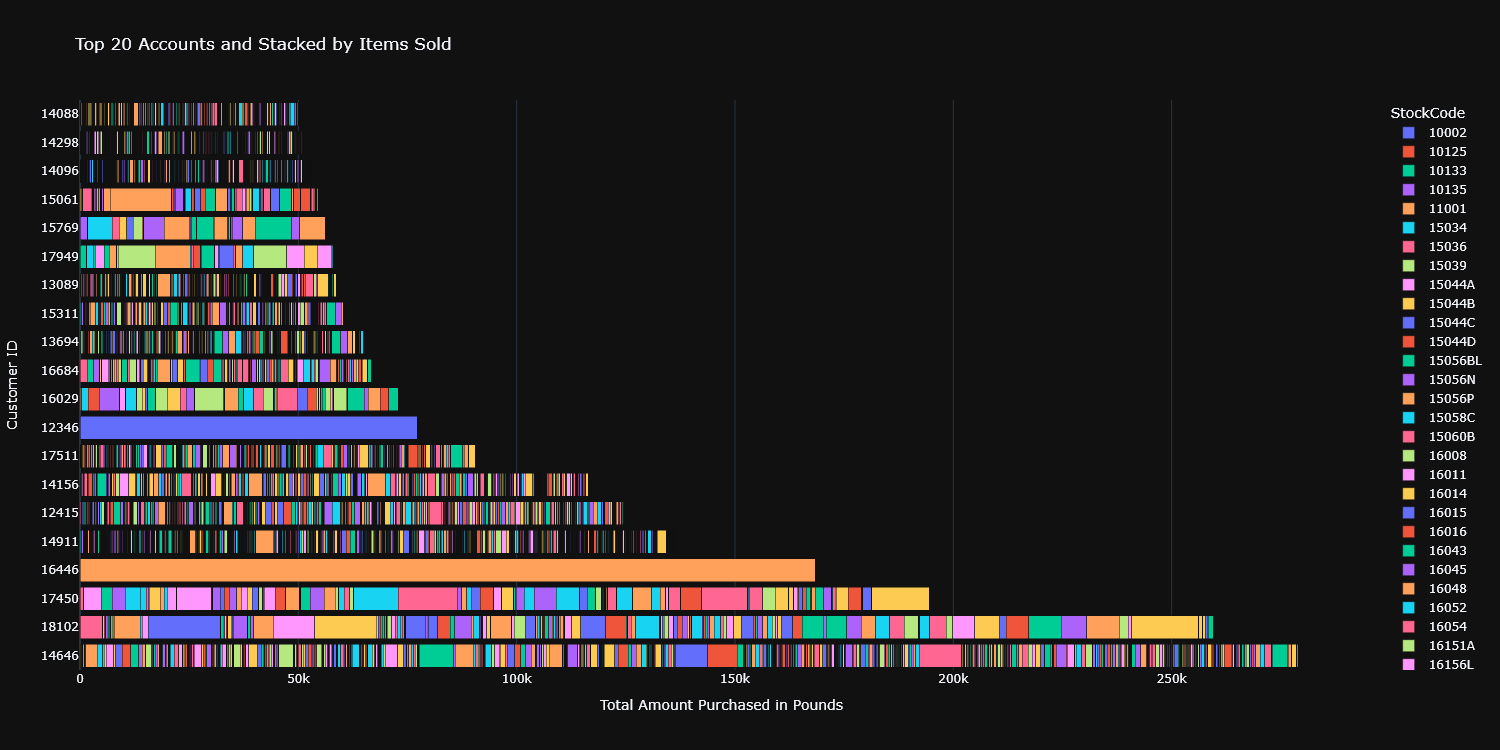

In [31]:
#Let's recreate the image above but as a stacked chart to include the different items purchased in order to see if we can determine a trend or pattern
#Create a dictionary to sort values based on amounts purchased for the top accounts
top_accounts_sorting = {}
for i in range (0, len(top_accounts_list)):
    top_accounts_sorting[top_accounts_list[i]] = i

#Groupe data by Customer IDs first and Stock Codes second, while summing up the total amounts purchased, then pivoting our dataframe so we can generate the needed data for our stacked bar chart
top_grouped_stock_reset = top_accounts_transactions[['CustomerID_str', 'StockCode', 'TotalPrice']].groupby(['CustomerID_str', 'StockCode']).sum().reset_index()
top_grouped_stock_reset = top_grouped_stock_reset.sort_values( by= 'CustomerID_str', key=lambda x:x.map(top_accounts_sorting))

pivot_df = top_grouped_stock_reset.pivot(index='CustomerID_str', columns='StockCode', values='TotalPrice').fillna(0)
pivot_df = pivot_df.sort_index(level = 1, key=lambda x:x.map(top_accounts_sorting))

#Plotting our stacked bar chart
fig = px.bar(pivot_df, orientation='h', title='Top 20 Accounts and Stacked by Items Sold')
fig.update_layout(barmode='stack', xaxis_title='Total Amount Purchased in Pounds', yaxis_title='Customer ID', height=750, width = 1500)
pio.write_image(fig, 'top_accounts_with_items_purchased.png')

Image('top_accounts_with_items_purchased.png')

In [32]:
#So from above we see that most of our top 20 customers buy a wide variety of items, but it is interesting to note the two accounts that each only purchase a single item
#For those that purchase more than one type of stock, we have customers that purchase a lot of items at small amounts, others that purchase more amounts but also a lower number of unique stock codes, and others like the top two accounts that are a mix of both
#To gain any other insights, we will have to do some clustering - which we will do on a separate notebook

In [33]:
#For now let's visualize other aspects of our data -  let's identify the countries from where our orders come from
countries_df = pd.DataFrame(df['Country'].value_counts().reset_index())

# Convert country names to ISO 3-letter codes
import country_converter as coco
countries_df['ISO'] = coco.convert(names=countries_df['Country'], to='ISO3')
display_side_by_side(countries_df[countries_df['ISO'] == 'not found'])

#Replace some of the country names to something that can be used with country converter, manually change Channel Islands ISO code
countries_df['Country'] = countries_df['Country'].replace({'EIRE':'Ireland', 'RSA':'South Africa'})
countries_df['ISO'] = coco.convert(names=countries_df['Country'], to='ISO3')
countries_df.at[11, 'ISO'] = 'GB-CHA'

#Filter out Countries that are not specific/unspecified
countries_to_remove = ['Unspecified', 'European Community']
countries_df_filtered = countries_df[~countries_df['Country'].isin(countries_to_remove)]



EIRE not found in regex
Channel Islands not found in regex
Unspecified not found in regex
European Community not found in regex
RSA not found in ISO3


,Country,count,ISO
3,EIRE,7779,not found
11,Channel Islands,744,not found
15,Unspecified,446,not found
30,European Community,57,not found
31,RSA,57,not found


Channel Islands not found in regex
Unspecified not found in regex
European Community not found in regex


In [35]:
#Convert count to log_counts to see better gradiation in Chloropeth map
countries_df_filtered['log_count'] = np.log(countries_df_filtered['count'])

# Load GeoJSON data
with urlopen('https://raw.githubusercontent.com/johan/world.geo.json/master/countries.geo.json') as response:
    countries = json.load(response)


# Create the choropleth map
fig = px.choropleth(countries_df_filtered, geojson=countries, locations='ISO', color='log_count', color_continuous_scale='reds', labels='count')
fig.update_geos(fitbounds="locations")
fig.update_layout(title= 'Chloropeth Map of Country based on Log Counts of Orders', title_x = 0.5, title_y = 0.95, margin={"r":0,"t":0,"l":0,"b":20})
fig.show()


In [36]:
#As expected, most of the orders come from the United Kingdom and the countries that are in close proximity, but we also see a good amount of orders from other countries with big economies such as Japan, USA, Canada, Australia and Brazil. It is also interesting to see that there are orders coming from places such as South Africa, Saudi Arabia, and United Arab Emirates 